# 🏍️ Automated Traffic Violation Reporter using VideoDB RTStream

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/video-db/videodb-cookbook/blob/main/real_time_streaming/Roadcam.ipynb)

## 📖 The Story Behind This

You've probably seen this [viral post](https://x.com/the2ndfloorguy/status/2007411050984157452?s=20) — a guy got so fed up with people breaking traffic rules around him every single day that he automated his helmet camera to:

* **📸 Snap a photo** of the violation
* **🔢 Capture** the vehicle number plate
* **📧 Auto-send** the evidence straight to the traffic police

The internet went wild. People loved it. Some called him a hero, others called him a snitch. But one thing's for sure - **the idea struck a chord**.

What if you could do the same? What if your dashcam or helmet cam could automatically catch rule-breakers and report them - **no manual effort needed**?

Well, with **VideoDB RTStream**, you absolutely can. Let's build it! 🚀

---

## 🚀 What We're Building

A real-time traffic violation detection system that:
- 🎥 Connects to a helmet cam / dashcam RTSP stream  
- 🤖 Uses AI to monitor for common rule violations (no helmet, wrong side, etc.)
- 🚨 Sends instant alerts with vehicle details to a webhook
- 📬 Hooks into n8n → email workflow to report violations automatically

Let's get to it!

---

## 📦 Step 1: Install & Setup

First, let's install VideoDB.

In [32]:
!pip install -q videodb

Now let's connect to VideoDB. Enter your API key when prompted.
>Get your API key from [VideoDB Console](https://console.videodb.io).

In [33]:
import videodb
import os
from getpass import getpass

api_key = getpass("Enter your VideoDB API Key: ")
os.environ["VIDEO_DB_API_KEY"] = api_key

conn = videodb.connect()
coll = conn.get_collection()

print("✅ Connected to VideoDB!")

Enter your VideoDB API Key: ··········
✅ Connected to VideoDB!


---

## 📦 Step 2: Connect to the Camera Stream

We'll connect to our helmet cam / dashcam RTSP feed. This is where the magic begins - our AI-powered traffic cop is about to go live. 👮

In [ ]:
rtsp_url = "rtsp://samples.rts.videodb.io:8554/roadcam"
roadcam_stream = coll.connect_rtstream(
    name="RoadCam Violation Stream",
    rtsp_url=rtsp_url,
)
print(roadcam_stream)

#### Already connected? Reconnect using your RTStream ID:

In [ ]:
# roadcam_stream = coll.get_rtstream("your-rtstream-id-here")

In [ ]:
# Stream controls (uncomment as needed)
# roadcam_stream.start()
# roadcam_stream.stop()

---

### 👀 Let's Preview the Stream

Use VideoDB's built-in player to check the live feed.

In [56]:
from videodb import play_stream
import time

# Get the last 2 minutes of stream
now = int(time.time())
stream_url = roadcam_stream.generate_stream(now - 120, now)

play_stream(stream_url)

---

## 📦 Step 3: Set Up Violation Detection Index

Now the fun part! We'll create a scene index that monitors every 5 seconds, analyzing 5 frames to catch rule-breakers.

Our AI will look for these common violations:
- 🪖 **No Helmet** - Two-wheeler riders without helmets
- 📱 **Mobile Phone Use** - Using phone while driving
- 🚗 **Wrong Side Driving** - Vehicles going against traffic flow
- 🚦 **Red Light Violation** - Crossing on red signal
- 👥 **Triple Riding** - More than 2 people on a two-wheeler
- 🚫 **No Seatbelt** - Four-wheeler occupants without seatbelts

In [ ]:
violation_prompt = """
Focus on vehicles visible on the road and monitor them for the following traffic rule violations:

1. NO HELMET: Two-wheeler (motorcycle/scooter) rider or pillion not wearing a helmet
2. MOBILE PHONE USE: Driver using mobile phone while operating the vehicle
3. WRONG SIDE DRIVING: Vehicle traveling against the designated traffic flow direction
4. RED LIGHT VIOLATION: Vehicle crossing the stop line or intersection when traffic signal is red
5. TRIPLE RIDING: More than two people riding on a single two-wheeler
6. NO SEATBELT: Driver or front passenger in a four-wheeler not wearing seatbelt

Analyze the frames carefully. If you detect one or more violations from the above list, respond EXACTLY in this format:

Traffic Rule Violated
Vehicle: [vehicle type and color, e.g., "Black motorcycle", "White sedan"]
Plate Number: [license plate number if visible, otherwise "Not Visible"]
Violation: [specific violation(s) from the list above]
Description: [brief description of what you observed]

If NO violation is detected, respond ONLY with:
No Traffic Rule Violation Detected
"""

violation_scene_index = roadcam_stream.index_visuals(
    batch_config={
        "type": "time",
        "value": 7,
        "frame_count": 5,
    },
    prompt=violation_prompt,
    name="Traffic_Violation_Index_7_5"
)

violation_index_id = violation_scene_index.rtstream_index_id
print(f"✅ Scene Index Created!")
print(f"Index ID: {violation_index_id}")

#### Already have a scene index? Reconnect:

In [ ]:
# violation_index_id = "your-index-id-here"
# violation_scene_index = roadcam_stream.get_scene_index(violation_index_id)

In [ ]:
# Index controls (uncomment as needed)
# violation_scene_index.start()
# violation_scene_index.stop()

---

### 🔍 Let's Check What the AI is Seeing

Give it a minute to start indexing, then run this cell to see the scene descriptions.

In [58]:
import time
from datetime import datetime
from zoneinfo import ZoneInfo

def _convert_to_ist(timestamp: float) -> str:
    """Convert UTC timestamp to IST (Asia/Kolkata) datetime string."""
    return (
        datetime.fromtimestamp(timestamp)
        .astimezone(ZoneInfo("Asia/Kolkata"))
        .strftime("%Y-%m-%d %H:%M:%S")
    )

def print_scenes(index):
    # Print indexed scenes
    scenes = index.get_scenes(page_size=5)
    if scenes:
        for scene in scenes.get("scenes"):
            start = _convert_to_ist(scene["start"])
            end = _convert_to_ist(scene["end"])
            description = scene["description"]
            print("-" * 80)
            print(f"{start}-{end}: {description}")
            print("-" * 80)
            print("\n")
    else:
        print("Scenes not found for given index.")

print_scenes(violation_scene_index)

--------------------------------------------------------------------------------
2026-01-07 18:09:58-2026-01-07 18:10:05: Traffic Rule Violated
Vehicle: White scooter
Plate Number: Not Visible
Violation: NO HELMET
Description: The rider and pillion of the white scooter visible to the left of the large brown truck are not wearing helmets.
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
2026-01-07 18:09:50-2026-01-07 18:09:57: Traffic Rule Violated
Vehicle: Black motorcycle
Plate Number: Not Visible
Violation: NO HELMET
Description: The pillion rider on the black motorcycle is not wearing a helmet.
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
2026-01-07 18:09:34-2026-01-07 18:09:40: Traffic Rule Violated
Vehicle: Black motorcycle
Plate Number: Not Visible
V

---

## 📦 Step 4: Create Violation Detection Event

Now we define the event that triggers when a violation is detected.

In [46]:
violation_event_id = conn.create_event(
    event_prompt="""
    Detect when a traffic rule violation occurs, such as no helmet, mobile phone use, wrong side driving, red light violation, triple riding, or no seatbelt.
    Your 'explanation' should not include any commentary, and should clearly mention the following things:
    Traffic Rule Violated
    Vehicle: [vehicle type and color, e.g., "Black motorcycle", "White sedan"]
    Plate Number: [license plate number if visible, otherwise "Not Visible"]
    Violation: [specific violation(s) from the list above]
    Description: [brief description of what you observed]
    """,
    label="traffic_violation"
)
print(f"✅ Event Created!")
print(f"Event ID: {violation_event_id}")

✅ Event Created!
Event ID: 11fc2440057d22ec


---

## 📦 Step 5: Attach Alert to Webhook

This is where the automation kicks in. Every time a violation is detected, an alert gets fired to your webhook.

You can create a free webhook endpoint on [Pipedream](https://pipedream.com) or use [n8n](https://n8n.io/integrations/videodb/) for more complex workflows.

In [ ]:
# Enter your webhook URL here
webhook_url = "https://9004ff3f8ceb97585be623a77a2700af.m.pipedream.net"

if webhook_url:
    violation_alert_id = violation_scene_index.create_alert(
        event_id=violation_event_id,
        callback_url=webhook_url,
        # ws_connection_id=ws.connection_id  # Optional: for WebSocket events
    )
    print(f"✅ Alert Created!")
    print(f"Alert ID: {violation_alert_id}")
else:
    print("⚠️ Please provide a webhook URL to create alerts.")

---

## 📡 Example Alert Payload

When a violation is detected, your webhook receives an alert like this:

```json
{
  "event_id": "event-11fc2440057d22ec",
  "label": "traffic_violation",
  "confidence": 1.0,
  "explanation": """
    Traffic Rule Violated
    Vehicle: Silver motorcycle
    Plate Number: CS 3936
    Violation: NO HELMET
    Description: The rider of the silver motorcycle is not wearing a helmet.
    """,
  "timestamp": "2026-01-07T12:20:02.716407+00:00",
  "start_time": "2026-01-07T17:49:18.606307+05:30",
  "end_time": "2026-01-07T17:49:25.306326+05:30",
  "stream_url": "https://rt.stream.videodb.io/manifests/rts-019b985e-35bd-7723-b498-9e0bfac14a9a/1767788358000000-1767788366000000.m3u8",
  "player_url": "https://console.videodb.io/player?url=https://rt.stream.videodb.io/manifests/rts-019b985e-35bd-7723-b498-9e0bfac14a9a/1767788358000000-1767788366000000.m3u8"
}
```

The `stream_url` gives you direct access to the violation clip - perfect for attaching to your email report! 🎬

### 🎥 View the Violation Clip

When you receive an alert, you can view the violation clip using the `stream_url`:

In [51]:
from videodb import play_stream

# Paste the stream_url from your alert here to view the violation clip
alert_stream_url = "https://rt.stream.videodb.io/manifests/rts-019b985e-35bd-7723-b498-9e0bfac14a9a/1767788358000000-1767788366000000.m3u8"
play_stream(alert_stream_url)

---

## 🔧 Alert Management

Control your alerts as needed:

In [48]:
# Disable alert
# violation_scene_index.disable_alert(violation_alert_id)

# Re-enable alert
# violation_scene_index.enable_alert(violation_alert_id)

---

## 📬 Connect to n8n for Email Alerts

Now comes the final piece - automating emails to traffic authorities!

Connect your webhook to an **n8n workflow** that:

1.  **Webhook Trigger**: Receives the raw event payload from the VideoDB Safety Agent immediately upon violation detection.
2.  **AI Data Extraction**: A dedicated VideoDB node parses the unstructured explanation string into a structured JSON object containing the License Plate, Vehicle Description, and Violation Type.
3.  **Status Polling Loop**: Implements an asynchronous 'Wait & Check' logic to monitor the AI's processing status, ensuring data is fully ready before moving to the next step.
4.  **Report Formatting**: A custom JavaScript node generates a high-contrast, professional HTML email template that maps the AI observations to a formal report structure.
5.  **Official Delivery**: The finalized report - complete with the dynamic subject line and a direct link to the video evidence- is dispatched instantly via the Gmail node to the Traffic Control Room.

Simple setup, powerful impact. 💪

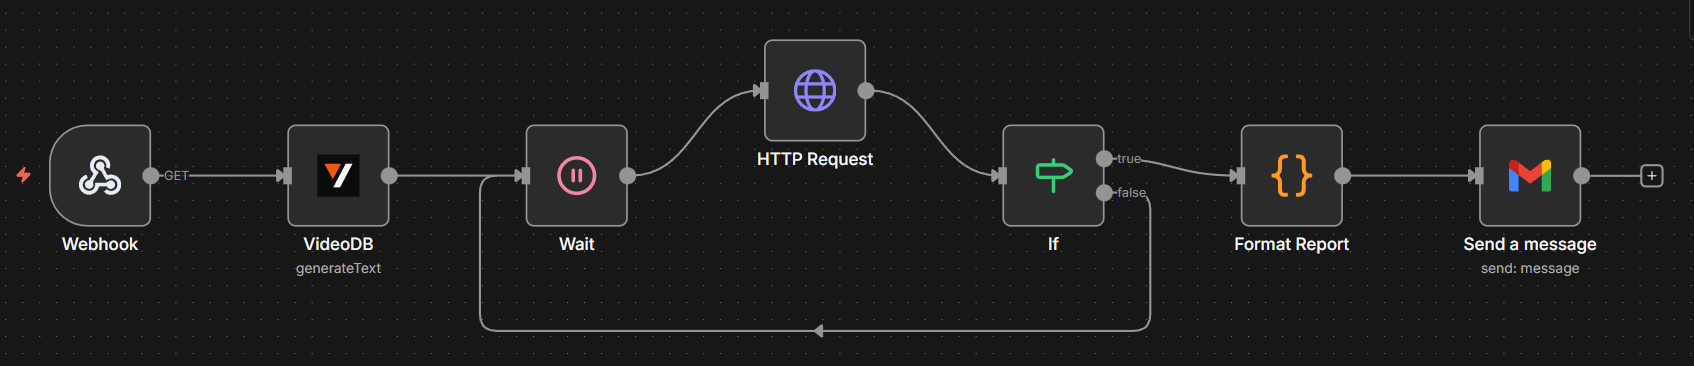

### The email we received for the above payload via the n8n workflow:
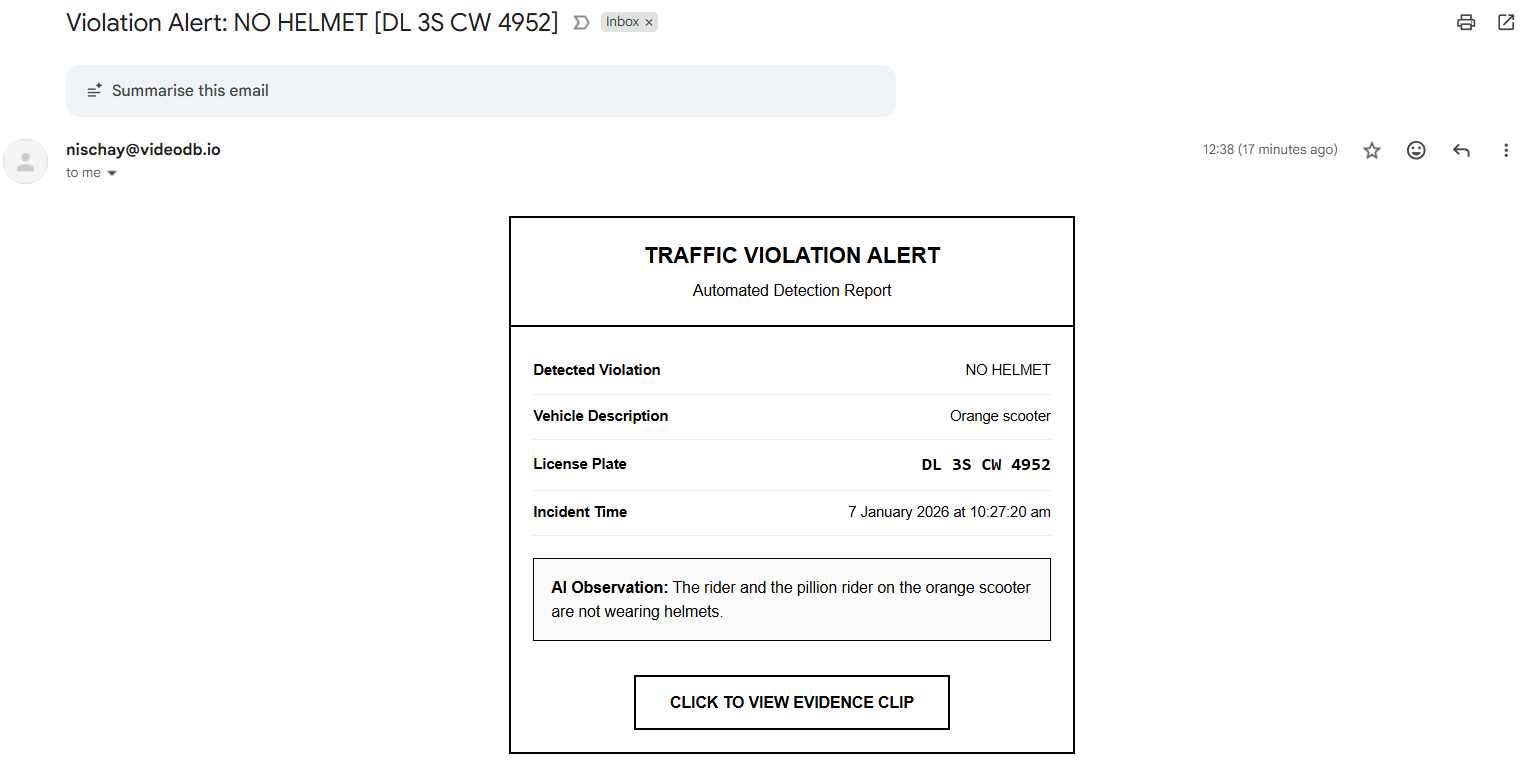

---

## 🧹 Cleanup

When you're done, stop the stream to conserve resources:

In [ ]:
# Stop the scene index
# violation_scene_index.stop()

# Stop the stream
# roadcam_stream.stop()

---

## 🏁 That's It!

You just built an automated traffic violation reporter. What started as one guy's viral protest is now something anyone can deploy.

**Small cameras. Smart AI. Big change.** 🚀

---

*Built with [VideoDB](https://videodb.io) - because every frame matters.*